# 05: Models

The team explored many avenues in the modeling process in order to get the most out of the datasets. Primarily the focus of the models was on both multi- and binary classification of animal outcomes with a great deal of additional work done in an effort to create a model to predict an animal's duration of stay. In the end, duration-of-stay models proved extremely unwieldly and none of the models designed to predict this metric performed reliably. This could potentially improve with additional data and/or with additional time to categorize some of the present features more effectively. Multi-class predictive models performed consistently well, scoring above the baseline with ease. However, the main focus of this project has been to create a model that predicts adoption outcomes specifically for animals that are entered into the Austin shelter system, and for that reason a simple binary classification model is the primary model used, both here and in the corresponding StreamLit app.

This notebook begins as usual, with primary imports, file reads, and a random seed:

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

In [25]:
np.random.seed(13)

In [26]:
df = pd.read_csv('../data/main.csv')

## I. Cleaning

In [27]:
# Removing columns before modeling
df.drop(columns=['outcome_type'], inplace=True)
df.drop(columns=['age_type'], inplace=True)

# Changing dtype
df['month_in'] = df['month_in'].astype(str)

## II. One-Hot Encoding the DataFrame

One-hot encoding ensures consitency encoding relevant variables when a user input information in the corresponding app. Here, `drop_first` is not used because predictive power is the main focus of this model/these models (rather than interpretability). Also, data is easier to split this way.

Here, columns are dummied and encoded as necessary, then re-merged. The final model is pickled.

In [28]:
# get our numeric columns
numeric = df.select_dtypes(exclude=object)

# get our categorical columns
categorical = df.select_dtypes([object])

# preserve the names of our categorical data
categorical_fnames = categorical.dtypes.keys() # preserve the names

# make sure you are importing one hot encoder, or this function will not work
enc = OneHotEncoder(sparse=False)

# categorical is now an array of arrays 
categorical = enc.fit_transform(categorical) 

dummy_cat_names = enc.get_feature_names(categorical_fnames)

categorical_df = pd.DataFrame(categorical, columns=dummy_cat_names)

df = pd.concat([numeric, categorical_df], axis=1)

In [29]:
pickle.dump(enc, open('../app/model/input_encoder.pkl','wb'))

## III. Modeling

Six separate models are created-- one for each of the following intake types:
1. Strays
2. Owner Surrender
3. Public Assist
4. Euthanasia Requests
5. Wildlife
6. Abandoned

### 1. Strays

Strays are the largest class of entries based on intake type, and Gradient Boosting is chosen because it consistently performed better than other explored models.

##### Filtering DataFrame:

In [30]:
model_df = df[df['intake_type_Stray'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline:

In [31]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.550385
1    0.449615
Name: adopted, dtype: float64


#### **Model**

X and y are created, then run through a train-test-split. 

In [32]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

A pipeline scales, then fits the training data to the GBC model:

In [33]:
pipe_params = [
  ('scaler', StandardScaler()),
  ('gbc', GradientBoostingClassifier(random_state=13))
]
stray_pipe = Pipeline(pipe_params)
stray_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(random_state=13))])

##### Scores:

In [34]:
print('Training Score: ', stray_pipe.score(X_train, y_train))
print('Testing Score: ', stray_pipe.score(X_test, y_test))

Training Score:  0.8328847084442293
Testing Score:  0.8286077212720592


The result is a well-fit model, scoring safely above 80% accuracy.

              precision    recall  f1-score   support

           0       0.92      0.76      0.83     12132
           1       0.75      0.92      0.83      9911

    accuracy                           0.83     22043
   macro avg       0.84      0.84      0.83     22043
weighted avg       0.84      0.83      0.83     22043



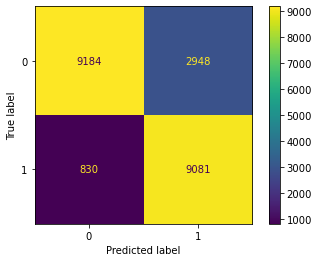

In [35]:
plot_confusion_matrix(stray_pipe, X_test, y_test);
print(classification_report(y_test, stray_pipe.predict(X_test)))

##### Pickling:

In [36]:
pickle.dump(stray_pipe, open('../app/model/stray_pipe.pkl','wb'))

### 2. Owner Surrenders

##### Filtering DataFrame:

In [37]:
model_df = df[df['intake_type_Owner Surrender'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline:

In [38]:
print(model_df['adopted'].value_counts(normalize=True))

1    0.633628
0    0.366372
Name: adopted, dtype: float64


#### **Model**

X and y are created, then run through a train-test-split. 

In [39]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

pipe_params = [
               ('scaler', StandardScaler()),
               ('gbc', GradientBoostingClassifier(random_state=13))
]
surrender_pipe = Pipeline(pipe_params)
surrender_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(random_state=13))])

##### Scores:


In [40]:
print('Training Score: ', surrender_pipe.score(X_train, y_train))
print('Testing Score: ', surrender_pipe.score(X_test, y_test))

Training Score:  0.7382001258653241
Testing Score:  0.7316344187509831


              precision    recall  f1-score   support

           0       0.78      0.37      0.50      2329
           1       0.72      0.94      0.82      4028

    accuracy                           0.73      6357
   macro avg       0.75      0.66      0.66      6357
weighted avg       0.74      0.73      0.70      6357



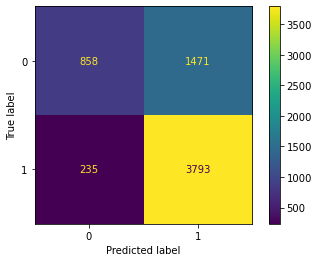

In [41]:
plot_confusion_matrix(surrender_pipe, X_test, y_test);
print(classification_report(y_test, surrender_pipe.predict(X_test)))

##### Pickling:

In [42]:
pickle.dump(surrender_pipe, open('../app/model/ownersurrender_pipe.pkl','wb'))

### 3. Public Assist

Filtering DataFrame:

In [43]:
model_df = df[df['intake_type_Public Assist'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline:

In [44]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.85573
1    0.14427
Name: adopted, dtype: float64


#### **Model**
X and y are created, then run through a train-test-split. 

In [45]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

pipe_params = [
               ('scaler', StandardScaler()),
               ('gbc', GradientBoostingClassifier(random_state=13))
]
passist_pipe = Pipeline(pipe_params)
passist_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(random_state=13))])

##### Scores:

In [46]:
print('Training Score: ', passist_pipe.score(X_train, y_train))
print('Testing Score: ', passist_pipe.score(X_test, y_test))

Training Score:  0.9064748201438849
Testing Score:  0.8977389516957862


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1665
           1       0.72      0.48      0.58       281

    accuracy                           0.90      1946
   macro avg       0.82      0.72      0.76      1946
weighted avg       0.89      0.90      0.89      1946



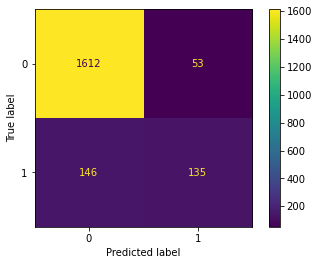

In [47]:
plot_confusion_matrix(passist_pipe, X_test, y_test);
print(classification_report(y_test, passist_pipe.predict(X_test)))

Baseline and model prep is provided in the cells above. Here, the accuracy score of the model rises along with the baseline score and performs well above the null model. Confusion matrix in the cell that follows:

##### Pickling:

In [48]:
pickle.dump(passist_pipe, open('../app/model/pubassist_pipe.pkl','wb'))

### 4. Euthanasia Requests

Euthanasia requests create a conundrum in model construction, as the model is designed to predict adoptions which has as an assumption that the purpose of bringing a specific animal into the shelter system is to facilitate adoption. The model for this intake type performs just barely above the baseline on the test data.

##### Filtering DataFrame:

In [49]:
model_df = df[df['intake_type_Euthanasia Request'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline:

In [50]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.945525
1    0.054475
Name: adopted, dtype: float64


#### **Model**
X and y are created, then run through a train-test-split. 

In [51]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

pipe_params = [
               ('scaler', StandardScaler()),
               ('gbc', GradientBoostingClassifier(random_state=13))
]
euth_req_pipe = Pipeline(pipe_params)
euth_req_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(random_state=13))])

##### Scores:

In [52]:
print('Training Score: ', euth_req_pipe.score(X_train, y_train))
print('Testing Score: ', euth_req_pipe.score(X_test, y_test))

Training Score:  1.0
Testing Score:  0.9538461538461539


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        61
           1       1.00      0.25      0.40         4

    accuracy                           0.95        65
   macro avg       0.98      0.62      0.69        65
weighted avg       0.96      0.95      0.94        65



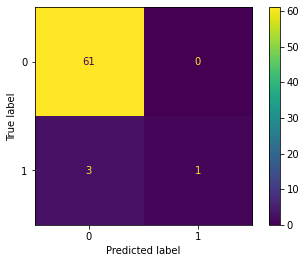

In [53]:
plot_confusion_matrix(euth_req_pipe, X_test, y_test);
print(classification_report(y_test, euth_req_pipe.predict(X_test)))

##### Pickling:

In [54]:
pickle.dump(euth_req_pipe, open('../app/model/euth_pipe.pkl','wb'))

### 5. Wildlife

Entries classified as wildlife for their intake type proved another challenge, as there are simply too few cases in the dataset of these animals being adopted to produce meaningful results. Bagging did not help and resulted in overfitting the model to the training data. Also, because the scope of the model focuses primarily on adoption outcomes, this may result in a deviation from a shelter's intentions for wildlife animals if adoption is not the primary goal for such cases.

For additional exploration, more data would be needed.

##### Filtering DataFrame:

In [55]:
model_df = df[df['intake_type_Wildlife'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline

In [56]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.998618
1    0.001382
Name: adopted, dtype: float64


#### **Model**
X and y are created, then run through a train-test-split. 

In [57]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

pipe_params = [
               ('scaler', StandardScaler()),
               ('gbc', GradientBoostingClassifier(random_state=13, learning_rate=.01))
]
wildlife_pipe = Pipeline(pipe_params)
wildlife_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            random_state=13))])

##### Scores:

In [58]:
print('Training Score: ', wildlife_pipe.score(X_train, y_train))
print('Testing Score: ', wildlife_pipe.score(X_test, y_test))

Training Score:  1.0
Testing Score:  0.9984214680347278


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1265
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       1.00      1.00      1.00      1267



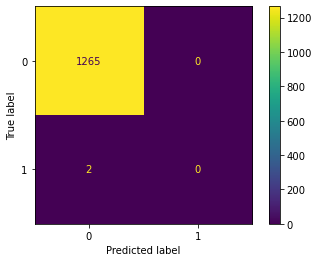

In [59]:
plot_confusion_matrix(wildlife_pipe, X_test, y_test);
print(classification_report(y_test, wildlife_pipe.predict(X_test)))

##### Pickling:

In [60]:
pickle.dump(euth_req_pipe, open('../app/model/wlife_pipe.pkl','wb'))

### 6. Abandoned

The iteration of this model used for abandoned animals again performs extremely well, and adjusting the initial model by finetuning hyperparameters reduced early overfitting.

##### Filtering DataFrame:

In [61]:
model_df = df[df['intake_type_Abandoned'] == 1]
model_df.reset_index(inplace=True, drop=True)

##### Baseline:

In [62]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.504525
1    0.495475
Name: adopted, dtype: float64


#### **Model**

In [63]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

pipe_params = [
               ('scaler', StandardScaler()),
               ('gbc', GradientBoostingClassifier(max_features=1000,learning_rate=.001,random_state=13))
]
abandoned_pipe = Pipeline(pipe_params)
abandoned_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features=1000,
                                            random_state=13))])

##### Scores:

In [64]:
print('Training Score: ', abandoned_pipe.score(X_train, y_train))
print('Testing Score: ', abandoned_pipe.score(X_test, y_test))

Training Score:  0.8731117824773413
Testing Score:  0.8288288288288288


              precision    recall  f1-score   support

           0       0.95      0.70      0.80        56
           1       0.76      0.96      0.85        55

    accuracy                           0.83       111
   macro avg       0.85      0.83      0.83       111
weighted avg       0.86      0.83      0.83       111



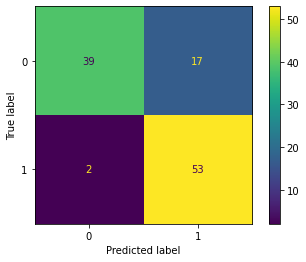

In [65]:
plot_confusion_matrix(abandoned_pipe, X_test, y_test);
print(classification_report(y_test, abandoned_pipe.predict(X_test)))

##### Pickling:

In [66]:
pickle.dump(euth_req_pipe, open('../app/model/abandoned_pipe.pkl','wb'))

## IV. Pickle Dump for Streamlit App

The DataFrames used for this modeling process is written to the `datasets` folder, and unique values for key categorical features are pickled for use in the StreamLit app:

In [67]:
pkl_df = pd.read_csv('./../data/main.csv')

In [68]:
pickle.dump(pkl_df['color'].unique(), open('../app/model/animal_color_list.pkl','wb'))
pickle.dump(pkl_df['animal_type'].unique(), open('../app/model/animal_type_list.pkl','wb'))
pickle.dump(pkl_df['breed'].unique(), open('../app/model/animal_breed_list.pkl','wb'))
pickle.dump(pkl_df['intake_condition'].unique(), open('../app/model/intake_cond_list.pkl','wb'))

# ***Model Deployment*** - [Streamlit App]('../app/main_app.py')